In [70]:
import pandas as pd
import importlib
import mpt_functions as mpt
importlib.reload(mpt)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from datetime import datetime, timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [48]:
f1_start = "2020-04-18 00:00:00"
f1_finish = "2020-04-18 23:59:00"
f2_start = "2020-05-29 23:30:00"
f2_finish = "2020-05-30 06:00:00"
f3_start = "2020-06-05 10:00:00"
f3_finish = "2020-06-07 14:30:00"
f4_start = "2020-07-15 14:30:00"
f4_finish = "2020-07-15 19:00:00"

# **************************************************************************************************************#

path = "/Users/abdullahfurkanarslan/Desktop/metropt+3+dataset 2/MetroPT3(AirCompressor).csv"
df = mpt.get_the_data_and_convert_datetime(path)

#

df = mpt.drop_a_column(df, "Unnamed: 0")

#

df = df.assign(condition=0)
df = mpt.change_the_values_by_applying_a_time_filter(df, f1_start, f1_finish, "condition", 1)
df = mpt.change_the_values_by_applying_a_time_filter(df, f2_start, f2_finish, "condition", 1)
df = mpt.change_the_values_by_applying_a_time_filter(df, f3_start, f3_finish, "condition", 1)
df = mpt.change_the_values_by_applying_a_time_filter(df, f4_start, f4_finish, "condition", 1)




# optional 1

df["data_point_number"] = df.index + 1

# optional 2

df  = mpt.counter_for_maintenance(df , "2020-02-01 00:00:00", f1_finish)
df  = mpt.counter_for_maintenance(df , f1_finish, f2_finish)
df  = mpt.counter_for_maintenance(df , f2_finish, f3_finish)
df  = mpt.counter_for_maintenance(df , f3_finish, f4_finish)
df = mpt.counter_for_maintenance(df, f4_finish, "2020-09-01 03:59:51")



#

all_column_names = df.columns.to_list()

name_of_the_categorical_columns = ['COMP', 'DV_eletric', 'Towers',
       'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses']

name_of_the_numerical_columns =["counter",'data_point_number','TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs',
       'Oil_temperature', 'Motor_current']

target_column = df["condition"]

#

df_scaled = mpt.scale_columns(df, name_of_the_numerical_columns)

# optional 3

df_clustered = mpt.apply_kmeans_clustering(df_scaled, 5, "condition")

In [60]:
datetime_column = df.columns[0]  # Adjust this if your datetime column isn't the first one

# Add month and week number columns
df_clustered['number_of_the_month'] = df_clustered[datetime_column].dt.month
df_clustered['number_of_the_week'] = df_clustered[datetime_column].dt.isocalendar().week
df_clustered["number_of_the_day"] = df_clustered[datetime_column].dt.isocalendar().day


df_clustered['number_of_the_month'] = df_clustered['number_of_the_month'].astype('float64')
df_clustered['number_of_the_week'] = df_clustered['number_of_the_week'].astype('float64')
df_clustered['number_of_the_day'] = df_clustered['number_of_the_day'].astype('float64')

In [61]:
def aggregate(df,aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8):
    

    result1 = mpt.get_the_probabilities_with_logistic_regressionn(df, n1, n2, m3, n4, n5, n6, n7, n8, "yes")

    probabilities = result1[0]
    y_test = result1[1]

    #probabilities = mpt.get_the_probabilities_with_logistic_regressionn(df, n1, n2, m3, n4, n5, n6, n7, n8, "yes")[0]
    #y_test = mpt.get_the_probabilities_with_logistic_regressionn(df, n1, n2, m3, n4, n5, n6, n7, n8, "no")[1]
    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition(df_ed, aggregation_size)
    return result


def agg_new_deneme(penalty, C_value, solver, max_iter,df,aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8, use1, use2, use3, use4, sliding_amount):

    result1 = mpt.get_the_probabilities_with_logistic_regressionn_new(penalty, C_value, solver, max_iter,df, n1, n2, m3, n4, n5, n6, n7, n8, "yes", use1, use2, use3, use4)

    probabilities = result1[0]
    y_test = result1[1]

    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition_sliding(df_ed, aggregation_size, sliding_amount)
    return result


def agg_random_forest(n, f, d, s, l, df, aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8, use1, use2, use3, use4, sliding_amount):


    result1 = mpt.get_the_probabilities_with_random_forest_new(n, f, d, s, l, df, n1, n2, m3, n4, n5, n6, n7, n8, "yes", use1, use2, use3, use4)


    probabilities = result1[0]
    y_test =result1[1]
    
    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition_sliding(df_ed, aggregation_size, sliding_amount)
    return result


def agg_single_tree(df,aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8, use1, use2, use3, use4, sliding_amount):


    result1 = mpt.get_the_probabilities_with_single_tree(df, n1, n2, m3, n4, n5, n6, n7, n8, "yes", use1, use2, use3, use4)


    probabilities = result1[0]
    y_test =result1[1]
    
    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition_sliding(df_ed, aggregation_size, sliding_amount)
    return result



def plot_probabilities_by_condition(df, threshold): # tekrar yazılacak

    indices = np.arange(df.shape[0])
    
    # Create figure
    plt.figure(figsize=(8, 5))
    
    # Plot points with condition=0 and proba <= threshold in blue
    mask_0_below = (df['condition'] == 0) & (df['proba'] <= threshold)
    plt.scatter(indices[mask_0_below], df.loc[mask_0_below, 'proba'], 
                color='blue', alpha=0.7, label='condition=0')
    
    # Plot points with condition=0 and proba > threshold in red
    mask_0_above = (df['condition'] == 0) & (df['proba'] > threshold)
    plt.scatter(indices[mask_0_above], df.loc[mask_0_above, 'proba'], 
                color='red', alpha=0.7, label=f'condition=0, proba>{threshold}')
    
    # Plot points with condition=1 in black
    mask_1 = df['condition'] == 1
    plt.scatter(indices[mask_1], df.loc[mask_1, 'proba'], 
                color='black', alpha=0.7, label='condition=1')

    
    # Add labels and title
    plt.title('Probablity of Failure')
    plt.xlabel('Index')
    plt.ylabel('Probability')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [122]:
def calculate_scores(df):
    
    # Condition değeri 1 olan satırları bul
    condition_1_rows = df[df['condition'] == 1].index.tolist()
    
    if not condition_1_rows:
        print("Condition değeri 1 olan satır bulunamadı.")
        return
    
    # Condition 1 olan grupları bul
    groups = []
    current_group = [condition_1_rows[0]]
    
    for i in range(1, len(condition_1_rows)):
        # Eğer ardışık indeksler ise aynı gruba ekle
        if condition_1_rows[i] == condition_1_rows[i-1] + 1:
            current_group.append(condition_1_rows[i])
        else:
            # Değilse yeni grup başlat
            groups.append(current_group)
            current_group = [condition_1_rows[i]]
    
    # Son grubu eklemeyi unutma
    if current_group:
        groups.append(current_group)
    
    # Early score hesaplama (her grup için ilk 1'den önceki 75 satır)
    early_score = 0
    early_rows_count = 0
    
    for group in groups:
        # Gruptaki ilk 1'in indeksi
        first_one_idx = group[0]
        # İlk 1'den önceki 75 satır (ya da mümkün olan maksimum)
        start_idx = max(0, first_one_idx - 400)
        rows_to_consider = df.iloc[start_idx:first_one_idx]

        for _, row in rows_to_consider.iterrows():
            if row['proba'] > 0.5:
                early_score += (row['proba'] - 0.45)
                early_rows_count += 1

    # False score hesaplama (condition=0 ve proba>0.4 olan yerler için)
    false_score = 0
    false_rows_count = 0
    condition_0_rows = df[df['condition'] == 0]
    
    for _, row in condition_0_rows.iterrows():
        if row['proba'] > 0.5:
            # 0.4'ü aşan kısmı topla
            false_score += (row['proba'] - 0.45)
            false_rows_count += 1


    false_score = -1*false_score + early_score
    # Sonuçları yazdır
    print(f"Early Score: {early_score:.6f} (kullanılan satır sayısı: {early_rows_count})")
    print(f"False Score: {false_score:.6f} (kullanılan satır sayısı: {false_rows_count})")
    
    return early_score, false_score

In [123]:
import pandas as pd
import random

def select_columns(df):
    required_cols = ['condition', 'timestamp', 'Oil_temperature', 'DV_pressure']
    selected_cols = required_cols.copy()

    # Zamanla ilgili sütunlar ya da data_point_number %100 olasılık içinde seçim yapılır
    choice = random.random()

    if choice < 0.1:
        selected_cols.append('data_point_number')
    elif choice < 0.2:
        selected_cols += ['number_of_the_month', 'number_of_the_week', 'number_of_the_day']
    elif choice < 0.3:
        selected_cols.append('number_of_the_month')
    elif choice < 0.4:
        selected_cols.append('number_of_the_week')
    elif choice < 0.5:
        selected_cols.append('number_of_the_day')
    # else: %50 ihtimalle hiçbirini alma → hiçbir şey eklenmiyor

    # Cluster sütunu %20 ihtimalle alınır
    if random.random() < 0.2:
        selected_cols.append('Cluster')

    # Diğer sütunlar %35 ihtimalle alınır
    remaining_cols = [
        'TP2', 'TP3', 'H1', 'Reservoirs', 'Motor_current', 'COMP', 'DV_eletric',
        'Towers', 'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses',
        'counter'
    ]
    for col in remaining_cols:
        if random.random() < 0.35:
            selected_cols.append(col)

    selected_cols = list(dict.fromkeys(selected_cols))
    return df[selected_cols]


In [151]:
def fit_the_model_and_get_the_best_scores(w_, n_, d_, l_, t_, df, a_=400, b_=100):

    score1_best = -100
    score2_best = -100
    total_score_best = -100

    opt_df = df
    opt_df_1 = df
    opt_df_2 = df

    best_set1 = []
    best_set2 = []
    best_set3 = []

    iteration = 0

    for i in n_:
        for j in d_:
            for k in l_:
                for t in t_:
                    for a in a_:
                        for b in b_:
                            for w in range(w_):
                                
                                    iteration += 1
                                    print(iteration)
                                    print()
                                    print(i,j,k, t)

                                    


                                    aggregation_size = a

                                    treshold_probability = 0.5

                                    dataframe = select_columns(df)

                                    print(dataframe.columns)

                                    aggregated_probabilities = agg_new_deneme("l2", 0.5, "lbfgs", 1000, dataframe, aggregation_size, 4, 2, 4, 2, 4, 2, 20, 40, "yes", "yes", "yes", "no", b)

                                    score1, score2 = calculate_scores(aggregated_probabilities)

                                    total_score = score1 + score2

                                    if total_score > total_score_best:

                                        total_score_best = total_score
                                        best_set1 = [iteration, i, j, k , t]
                                        print("better is found for total")
                                        opt_df = dataframe

                                    if score1 > score1_best:

                                        score1_best = score1
                                        best_set2 = [iteration, i, j, k , t]
                                        print("better is found for 1")
                                        opt_df_1 = dataframe


                                    if score2 > score2_best:

                                        score2_best = score2
                                        best_set3 = [iteration, i, j, k , t]
                                        print("better is found for 2")
                                        opt_df_2 = dataframe


                                    print()
                                    print("********************************************************************************************************************************************************************************************************************************************************************************")
                                    print()

    print(best_set1, total_score_best)
    print(best_set2, score1_best)
    print(best_set3, score2_best)

    return opt_df, opt_df_1, opt_df_2

                

In [152]:
df = df_clustered.copy()

In [153]:
df.columns.tolist()

['timestamp',
 'TP2',
 'TP3',
 'H1',
 'DV_pressure',
 'Reservoirs',
 'Oil_temperature',
 'Motor_current',
 'COMP',
 'DV_eletric',
 'Towers',
 'MPG',
 'LPS',
 'Pressure_switch',
 'Oil_level',
 'Caudal_impulses',
 'condition',
 'data_point_number',
 'counter',
 'Cluster',
 'number_of_the_month',
 'number_of_the_week',
 'number_of_the_day']

In [165]:
list1 = ["l2"]
list2 = [1, 0.5, 0.75, 0.8, 0.6]
list3 = ["lbfgs", "liblinear", "saga"]
list4 = [50, 100, 250, 500, 1000]
a = [400, 800, 200]
b = [100, 50, 75, 150]

In [166]:
opt_df1, opt_df_p, opt_df_n = fit_the_model_and_get_the_best_scores(2, list1, list2, list3 , list4 , df)

1

l2 1 lbfgs 50
Index(['condition', 'timestamp', 'Oil_temperature', 'DV_pressure', 'Cluster',
       'TP3', 'counter'],
      dtype='object')
5
(5, 5)
                 Coefficient  p_value
Oil_temperature     3.749900      0.0
Cluster             3.131388      0.0
counter             2.781568      0.0
TP3                -2.002767      0.0
DV_pressure         0.155505      0.0
Intercept: -16.65835240208746
R-squareddd: 0.9458303862706016
F-Value: 550670.3236101049
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: -0.198808 (kullanılan satır sayısı: 2)
better is found for total
better is found for 1
better is found for 2

********************************************************************************************************************************************************************************************************************************************************************************

2

l2 1 lbfgs 50
Index(['condition', 'timestamp', 'Oil_temperature', 'DV_pressure',

8
(8, 8)
                 Coefficient  p_value
H1                 -3.035622      0.0
Motor_current      -2.995011      0.0
Oil_temperature     1.515587      0.0
counter             1.298455      0.0
DV_pressure         1.243288      0.0
MPG                -0.632233      0.0
Caudal_impulses    -0.358774      0.0
Towers             -0.125958      0.0
Intercept: -6.210175028656344
R-squareddd: 0.8914456430188464
F-Value: 161865.20861516127
Early Score: 0.233467 (kullanılan satır sayısı: 2)
False Score: 0.000000 (kullanılan satır sayısı: 2)


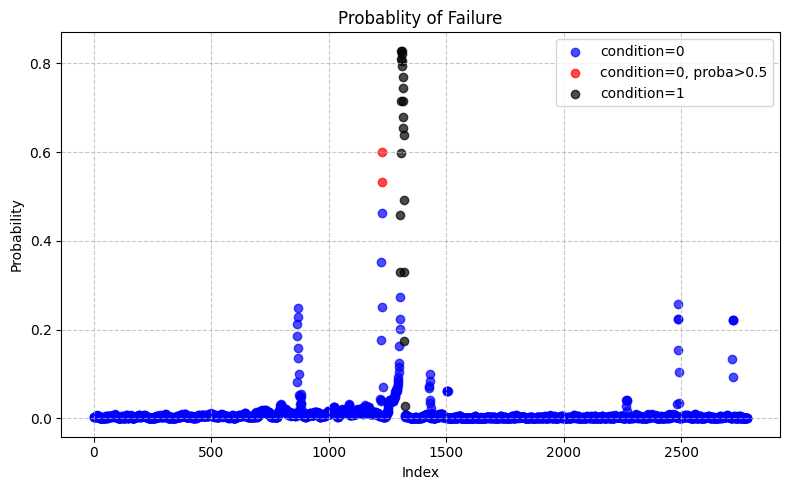

Index(['condition', 'timestamp', 'Oil_temperature', 'DV_pressure', 'H1',
       'Motor_current', 'Towers', 'MPG', 'Caudal_impulses', 'counter'],
      dtype='object')


In [174]:
aggregation_size = 400

treshold_probability = 0.5

aggregated_probabilities = agg_new_deneme("l2", 0.6 , "lbfgs", 100, opt_df1, aggregation_size, 4, 2, 4, 2, 4, 2, 20, 20, "yes", "yes", "yes", "no", 100)

calculate_scores(aggregated_probabilities)

plot_probabilities_by_condition(aggregated_probabilities, treshold_probability)

print(opt_df1.columns)

In [175]:
opt_df1, opt_df_p, opt_df_n = fit_the_model_and_get_the_best_scores(20, list1, list2, list3 , list4 , df)

1

l2 1 lbfgs 50
Index(['condition', 'timestamp', 'Oil_temperature', 'DV_pressure', 'TP2',
       'TP3', 'H1', 'DV_eletric', 'Pressure_switch', 'Oil_level', 'counter'],
      dtype='object')
9
(9, 9)
                 Coefficient  p_value
Oil_temperature     3.188284      0.0
counter             2.813997      0.0
H1                 -2.198309      0.0
TP2                -1.869059      0.0
TP3                -1.663513      0.0
Oil_level          -1.380014      0.0
DV_pressure         1.219296      0.0
Pressure_switch     0.663093      0.0
DV_eletric         -0.461198      0.0
Intercept: -8.065033812749801
R-squareddd: 0.9454861790348309
F-Value: 303877.95035306644
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: -1.087535 (kullanılan satır sayısı: 6)
better is found for total
better is found for 1
better is found for 2

************************************************************************************************************************************************************

11
(11, 11)
                    Coefficient       p_value
counter                2.834405  0.000000e+00
Oil_level              2.684446  0.000000e+00
Oil_temperature        2.620331  0.000000e+00
COMP                  -2.528726  0.000000e+00
MPG                   -2.501139  0.000000e+00
DV_pressure            1.075237  0.000000e+00
TP2                   -1.025355  0.000000e+00
TP3                   -0.913090  0.000000e+00
Reservoirs            -0.604045  2.882139e-13
Towers                 0.209198  0.000000e+00
number_of_the_week     0.206672  0.000000e+00
Intercept: -11.419095065227388
R-squareddd: 0.9420441066771249
F-Value: 233006.78938052367
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


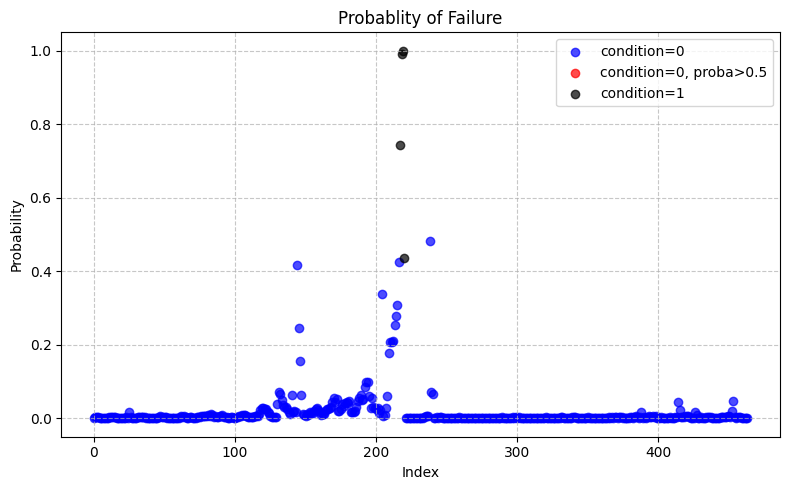

Index(['condition', 'timestamp', 'Oil_temperature', 'DV_pressure',
       'number_of_the_week', 'TP2', 'TP3', 'Reservoirs', 'COMP', 'Towers',
       'MPG', 'Oil_level', 'counter'],
      dtype='object')


In [185]:
aggregation_size = 750

treshold_probability = 0.5

aggregated_probabilities = agg_new_deneme("l2", 0.6 , "lbfgs", 50, opt_df1, aggregation_size, 4, 2, 4, 2, 4, 2, 20, 20, "yes", "yes", "yes", "no", 600)

calculate_scores(aggregated_probabilities)

plot_probabilities_by_condition(aggregated_probabilities, treshold_probability)

print(opt_df1.columns)

In [ ]:
opt_df1, opt_df_p, opt_df_n = fit_the_model_and_get_the_best_scores(20, list1, list2, list3 , list4 , df, a, b)